In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = r"Data\\"

In [2]:
from TransformData import transform_data
data_generator = transform_data(path = path + 'train.csv')
data = data_generator.get_data(train_or_analysis = 'train')

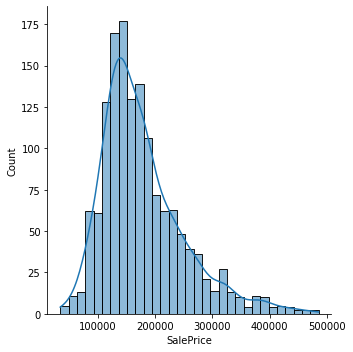

In [3]:
data.SalePrice = np.exp(data.SalePrice)
data = data.loc[data.SalePrice < 500000]
sns.displot(data.SalePrice, kde = True);

In [4]:
data.SalePrice = np.log(data.SalePrice)

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

params = {'lambda': 3.792404253903758, 'alpha': 3.720406654006611, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.027569142191457396, 'max_depth': 7, 'random_state': 1, 'min_child_weight': 26}
params2 = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}
x = data.drop('SalePrice', axis = 1)
y = data['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
reg = XGBRegressor(eval_metric= 'rmse', n_estimators = 1433, **params2)#, early_stopping_rounds = 50, **params)
reg.fit(x, y, 
        #eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.98
MSE: 0.00
RMSE: 0.0554
MAPE: 0.32%


In [22]:
tests = cross_val_score(reg, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
np.mean(tests)

-0.11992129898313716

In [23]:
importances = pd.DataFrame(columns = ['feature_importances'], data = reg.feature_importances_, index = reg.feature_names_in_).sort_values(by = 'feature_importances', ascending = False)


zero_importance= list(importances.loc[importances['feature_importances'] == 0].reset_index()['index'])
importances

,feature_importances
GarageCond_TA,0.148690
ExterQual_TA,0.100261
OverallQual,0.100024
Fireplaces,0.070341
FullBath,0.067178
...,...
Condition1_PosA,0.000000
Neighborhood_Veenker,0.000000
Foundation_Slab,0.000000
Foundation_Stone,0.000000


In [18]:
def objective(trial):
    x = data.drop('SalePrice', axis = 1)
    y = data['SalePrice']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
    param = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [1]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param, eval_metric= 'rmse')  
    model.fit(x_train,y_train,eval_set=[(x_train, y_train), (x_test, y_test)],verbose=False)
    preds = model.predict(x_test)
    tests = cross_val_score(model, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
    return np.mean(tests)

In [19]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-07 23:58:47,519] A new study created in memory with name: no-name-c3b73186-1af7-4277-baf5-e016ddddf882
[I 2023-05-07 23:59:51,993] Trial 0 finished with value: -0.39013843290074224 and parameters: {'lambda': 6.843764118504788, 'alpha': 3.2519994484812527, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.05026769979493771, 'max_depth': 11, 'random_state': 1, 'min_child_weight': 261}. Best is trial 0 with value: -0.39013843290074224.
[I 2023-05-08 00:00:50,517] Trial 1 finished with value: -0.1357397865956603 and parameters: {'lambda': 3.622943473920016, 'alpha': 6.129612529893727, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.051247952069980146, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 33}. Best is trial 1 with value: -0.1357397865956603.
[I 2023-05-08 00:01:51,587] Trial 2 finished with value: -0.1700286569475164 and parameters: {'lambda': 6.828503879440374, 'alpha': 9.586577652292213, 'colsample_bytree': 0.6, 'subsample': 0.6, 'lea

Number of finished trials: 200
Best trial: {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}


In [29]:
data_generator = transform_data(path = path + 'test.csv')
test = data_generator.get_data(train_or_analysis = 'train')
#cancel = ['Exterior1st_Stone', 'Utilities_NoSeWa', 'GarageQual_Ex', 'PoolQC_Fa', 'MiscFeature_TenC', 'Condition2_RRNn', 'Electrical_Mix', 'Condition2_RRAe', 'Exterior2nd_Other', 'Exterior1st_CBlock', 'RoofMatl_Roll', 'RoofMatl_Metal', 'RoofMatl_Membran', 'RoofMatl_ClyTile', 'HouseStyle_2.5Fin', 'Heating_Floor', 'Heating_OthW', 'Condition2_RRAn', 'Exterior1st_ImStucc']
#zero_importance = [column for column in zero_importance if column in cancel]
#test = test.drop(zero_importance, axis = 1)
test = test.set_index('Id')
test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,2.995732,4.382027,9.360655,1.609438,1.791759,7.581210,7.581210,0.000000,6.150603,4.976734,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,2.995732,4.394449,9.565704,1.791759,1.791759,7.579679,7.579679,4.691348,6.828712,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,4.094345,4.304065,9.534595,1.609438,1.609438,7.599401,7.599902,0.000000,6.674561,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1464,4.094345,4.356709,9.208138,1.791759,1.791759,7.599902,7.599902,3.044522,6.401917,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1465,4.787492,3.761200,8.518193,2.079442,1.609438,7.596894,7.596894,0.000000,5.575949,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,5.075174,3.044522,7.568379,1.386294,1.945910,7.585789,7.585789,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2916,5.075174,3.044522,7.546446,1.386294,1.609438,7.585789,7.585789,0.000000,5.533389,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2917,2.995732,5.075174,9.903488,1.609438,1.945910,7.580700,7.598900,0.000000,7.110696,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
missing_columns = [i for i in x.columns if i  not in test.columns]
for i in missing_columns:
    test[i] = 0
test = test[x.columns]
preds = np.exp(reg.predict(test))

In [31]:
test.drop('Id', axis = 1).reset_index()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,2.995732,4.382027,9.360655,1.609438,1.791759,7.581210,7.581210,0.000000,6.150603,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1462,2.995732,4.394449,9.565704,1.791759,1.791759,7.579679,7.579679,4.691348,6.828712,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1463,4.094345,4.304065,9.534595,1.609438,1.609438,7.599401,7.599902,0.000000,6.674561,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1464,4.094345,4.356709,9.208138,1.791759,1.791759,7.599902,7.599902,3.044522,6.401917,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1465,4.787492,3.761200,8.518193,2.079442,1.609438,7.596894,7.596894,0.000000,5.575949,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,5.075174,3.044522,7.568379,1.386294,1.945910,7.585789,7.585789,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,2916,5.075174,3.044522,7.546446,1.386294,1.609438,7.585789,7.585789,0.000000,5.533389,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,2917,2.995732,5.075174,9.903488,1.609438,1.945910,7.580700,7.598900,0.000000,7.110696,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,2918,4.442651,4.127134,9.253496,1.609438,1.609438,7.596894,7.596894,0.000000,5.823046,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
output = pd.DataFrame({'Id': test.drop('Id', axis = 1).reset_index()['Id'],
                       'SalePrice': preds})
output

,Id,SalePrice
0,1461,126565.000000
1,1462,156268.750000
2,1463,184471.781250
3,1464,195039.578125
4,1465,183555.218750
...,...,...
1454,2915,83800.164062
1455,2916,84638.109375
1456,2917,161694.562500
1457,2918,114600.906250


In [35]:
output.to_csv(path + 'submission.csv', index= False)

In [36]:
output

,Id,SalePrice
0,1461,126565.000000
1,1462,156268.750000
2,1463,184471.781250
3,1464,195039.578125
4,1465,183555.218750
...,...,...
1454,2915,83800.164062
1455,2916,84638.109375
1456,2917,161694.562500
1457,2918,114600.906250
